## Definition

**Domain adaptation** ( a term sometimes interchangebaly used with transfer learning ) aims to learn from a source data distribution or source task a well performing model on target data distribution or a target task 

A domain $\mathcal{D}$ and task $\mathcal{T}$ define the model. A **domain** $\mathcal{D} = \{\mathcal{X}, P(X)\}$ consists of a  domain space $\mathcal{X}$ and the marginal distribution of the data samples $X = \{x_{1}, x_{2}, x_{3}, \cdots, x_{n}\}$. A **task** $\mathcal{T} = \{\mathcal{Y}, P(T|X)\}$ consists of the label space $\mathcal{Y}$ and the conditional distribution $P(Y|X)$ of data samples on the label set $Y = \{y_{1}, y_{2}, y_{3}, \cdots, y_{n}\}$.

For this tutorial, we denote the source domain as $\mathcal{D}_{S} = \{\mathcal{X}_{S}, P(X_{S})\}$ and the target domain as $\mathcal{D}_{T} = \{\mathcal{X}_{T}, P(X_{T})\}$ where  $X_{S} = \{x^{S}_{1}, x^{S}_{2}, x^{S}_{3}, \cdots, x^{S}_{n}\}$ and $X_{T} = \{x^{T}_{1}, x^{T}_{2}, x^{T}_{3}, \cdots, x^{T}_{m}\}$.

## Need

We need domain adaptation becasuse target domain or task may be different from the source domain and task in a variety of ways

- Domain
  - Domain space $\mathcal{X}_{S}  \neq \mathcal{X}_{T}$
  - Marginal distribution $P(X_{S}) \neq P(X_{T})$

- Task 
  - Label space $\mathcal{Y}_{S} \neq \mathcal{Y}_{T}$
  - Conditional distribution $P(Y_{S}|X_{S}) \neq P(Y_{T}|X_{T})$
  
Moreover, the number of data samples in the target domain ($m$) may not be sufficient to train a plausible classifier.  [ Overfitting  ]. Let's take the example of MNIST and SVHN datasets to get a flavour of these concepts.


## Example

Take the example of two datasets MNIST and SVHN.

### MNIST (Handwritten Cheques) Samples 

- Contains digits 0 to 9
- Size of a single image in MNIST dataset is $28x28$
- $||X_{\text{MNIST}}|| = 28x28 = 784$
- Every image of MNIST lies in a 784-dimensional space

<center><img  height="300" width="300" align="middle" src="https://docs.google.com/uc?export=download&id=189T4iF6Rr2V2Zoj5T2UlCWas4g-gNYEe"></center>

### SVHN (Street View House Numbers) Samples

- Contains digits 0 to 9
- Size of a single image in MNIST dataset is $32x32x3 $
- $||X_{\text{SVHN}}|| = 32x32x3 = 3072 $
- Every image of SVHN lies in 3072-dimensional space

<center><img  height="300" width="300" align="middle" src="https://docs.google.com/uc?export=download&id=17WBe_yplFYlOIdMfSrkLs2QXiSghuu_n"></center>

#### Question 1 Let's check our understanding through a MCQ. Take source as MNIST and target as SVHN. As per the definitons given in Section 1, answer the following :-
-  Is $||\mathcal{X}_{S}|| = ||\mathcal{X}_{T}||$ ? 
-  Is $||\mathcal{Y}_{S}|| = ||\mathcal{Y}_{T}||$ ?
-  Is $P(Y_{S}|X_{S}) = P(Y_{T}|X_{T})$ ?
- Is $P(X_{S}) = P(X_{T})$ ?

## Approach

Although various methods have been proposed towards addressing domain adaptation problem., we will learn about domain alignment using adversarial learning in this notebook. To illustrate, let's take an example in lower-dimensions as it can be visualized. *Red*  points denote the classes in source domain and *blue* points denote the points in target domain. As we can observe, the classifier in the source domain ( the pink plane ) is not be able to classify the samples in the target domain. 

**Subspace alignment** - Set of domain adaptation techniques which try to align the samples in the target domain to the samples in the source domain. When both the domains are aligned, the classifer trained on source domain is also able to classify the samples in the target domain.

<center><img  height="400" width="500" align="middle" src="https://docs.google.com/uc?export=download&id=1BWSwGOlvgCcJZe9YgvyATp4HsgwcI9KT"></center>


**Adversarial Subspace Alignment** - Techinques which make use of an adversarial agent to align the source and target domain.

<center><img  height="400" width="500" align="middle" src="https://docs.google.com/uc?export=download&id=1jMjYCYLQ9YhJMBUS66Pyd4yR9ZJvMmRG"></center>






## Experimental Section

In this tutorial, we will go through two popular techniques to address domain adaptation. 


- Adversarial [Adversarial Discriminative Domain Adaptation](https://arxiv.org/pdf/1702.05464.pdf)

We will understand both these techniques through toy examples and proceed to apply them on existing computer vision datasets.

In the following toy example, we assume that both the source and target domain lie in a 2-dimensional space. Formally, $||X_{S}|| = ||X_{T}|| = 2$. However, the domains are defined such that they do not align.

#### Loading standard liberaries

In [1]:
# importing the ususal stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

# plotting the figures
import matplotlib.pyplot as plt
%matplotlib inline

# off-the shelf classifier for use
from sklearn.linear_model import LogisticRegression

# progress bar
from tqdm import tqdm_notebook as tqdm

#### Getting source domain samples

Defining two classes A ( Red triangle ) and B (Red circle)  in the souce domain such that $\mu_{A} \neq \mu_{B}$.


In [2]:
## Source Domain 

# class A (Red Triangle)
n_source_A = 100
mean_source_A = [-2,0]
std_source_A = 0.1
cov_source_A = std_source_A*np.eye(2) 

# class B (Red Circle)
n_source_B = 100
mean_source_B = [-2,+2]
std_source_B = 0.1
cov_source_B = std_source_B*np.eye(2) 

In [3]:
# class A and labels
X_source_A = np.random.multivariate_normal(mean_source_A, cov_source_A, n_source_A)
Y_source_A = np.ones(n_source_A)

# class B and labels
X_source_B = np.random.multivariate_normal(mean_source_B, cov_source_B, n_source_B)
Y_source_B = np.zeros(n_source_B)

# concatenate data samples and labels 

X_source_train = np.append(X_source_A, X_source_B, axis=0)
Y_source_train = np.append(Y_source_A, Y_source_B, axis=0)

#### Let's train a standard classifier on this data

In [4]:
# binary classifier to disambiguate class A and B 

logisticR = LogisticRegression()
logisticR.fit(X_source_train, Y_source_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Plot the classifier along with the source domain data

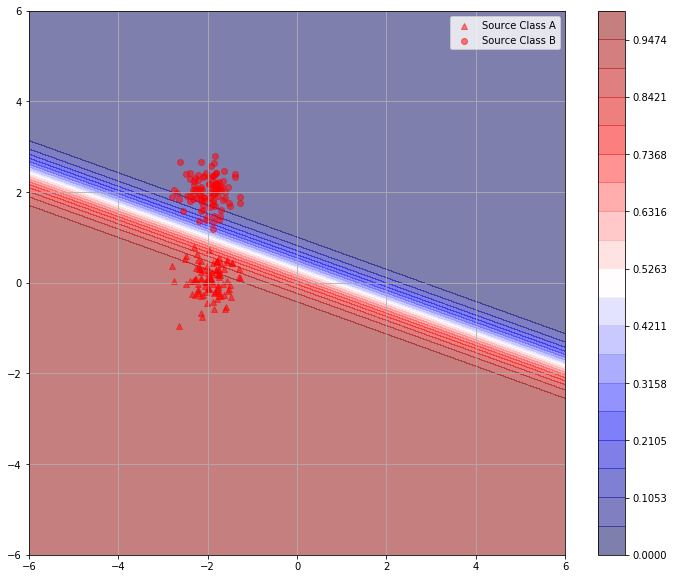

In [5]:
plt.figure(figsize=(12,10))

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logisticR.predict_proba(grid)[:, 1].reshape(xx.shape)

levels = np.linspace(0,1,20)
cm = plt.cm.seismic

cont = plt.contourf(xx, yy, probs, levels, cmap=cm, alpha=.5)

plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)


plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()

Clearly the classifier is able to classify A and B in the source domain.

#### Getting target domain samples

In [6]:
## Target data. Note that the target domain classes has differnt mean than their source domain counterparts.
## In other words, they are not aligned. Hence a classifier trained on source does not classify the target domain.

## class A (Blue Triangle)

n_target_A = 100
mean_target_A = [+2,0]
std_target_A = 0.1
cov_target_A = std_target_A*np.eye(2) 


## Class B (Blue Circle)

n_target_B = 100
mean_target_B = [+4,+0]
std_target_B = 0.1
cov_target_B = std_target_B*np.eye(2)

In [7]:
# target class A

X_target_A = np.random.multivariate_normal(mean_target_A, cov_target_A, n_target_A)
Y_target_A = np.ones(n_source_A)

# target class B

X_target_B = np.random.multivariate_normal(mean_target_B, cov_target_B, n_target_B)
Y_target_B = np.zeros(n_target_B)

#### Plotting the source domain classifier with the target domain data

As expected, notice that the source domain classifier is not able to classify target domain instances. 

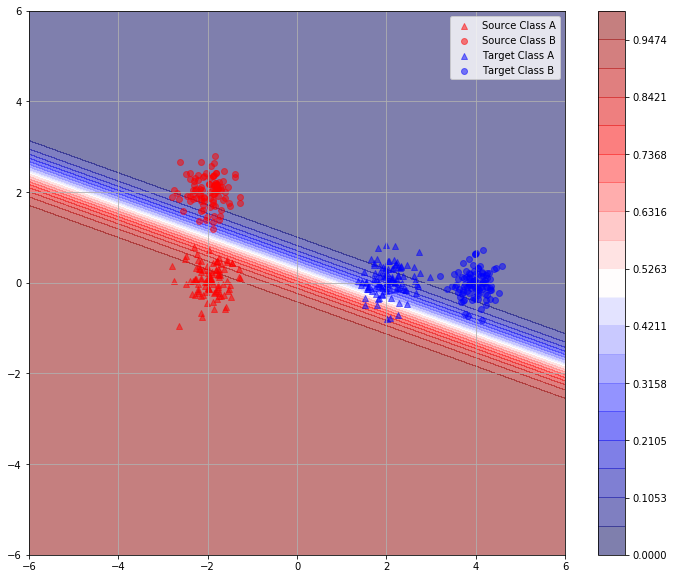

In [8]:
plt.figure(figsize=(12,10))

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logisticR.predict_proba(grid)[:, 1].reshape(xx.shape)

levels = np.linspace(0,1,20)
cm = plt.cm.seismic

cont = plt.contourf(xx, yy, probs, levels, cmap=cm, alpha=.5)

plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)

plt.scatter(X_target_A[:,0], X_target_A[:,1], label="Target Class A", color="blue", marker ="^", alpha=0.5)
plt.scatter(X_target_B[:,0], X_target_B[:,1], label="Target Class B", color="blue", alpha=0.5)


plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()


#### What now ? Adversarial Subspace Alignment to the rescue !!

To classify with the target data we would need to "align" the target domain to the source domain. In this particular notebook, we will use "adversarial" learning to align the source domain to the target domain and re-learn the classifier. 

In this particular exercise, we take $F_{1} = I$ and learn $F_{2}$ using an adversarial approach.

#### Discriminator

<center><img  height="250" width="400" align="middle" src="https://docs.google.com/uc?export=download&id=1ogtdDHZuGXEaJouBckz7_Bl3mcu-9HOL"></center>


In [9]:
class discriminator(nn.Module):
  
  def __init__(self, input_dims, hidden_dims, output_dims):
    ''' Init discriminator'''
    
    super(discriminator, self).__init__()
    
    self.fc1 = nn.Linear(input_dims, hidden_dims[0])
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc3 = nn.Linear(hidden_dims[1], output_dims)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    
    return x

#### Generator (called Transformer in this experiment)

<center><img  height="200" width="300" align="middle" src="https://docs.google.com/uc?export=download&id=18Ia3iRxztsqVsH9SO5zpUe79ZdIWcZ97"></center>


In [10]:
class transformer(nn.Module):
  ''' Generate a transformed version of source domain such that source and target domain are indistinguishible'''
  
  def __init__(self, input_dims, output_dims):
    
    super(transformer, self).__init__()
    
    # affine transformation y = Wx+b
    self.fc1 = nn.Linear(input_dims, output_dims)
    torch.nn.init.eye_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    
    
    #torch.nn.init.zeros_(self.fc1.weight)
    
  def forward(self, x):
    
    x = self.fc1(x)
    return x

#### Pyrorch Utilities

In [11]:
def convert_to_variable(tensor, volatile=False):
  '''Convert tensor to torch variable'''
  
  if torch.cuda.is_available():
    tensor = tensor.cuda()
    
  return Variable(tensor, volatile=volatile)

In [12]:
def select(tensor, labels):
    """ Input: (N,2) tensor and a (N,) labels tensor
        Output: (N,1) tensor, whose each element i correspond to the column labels[i] of 
        Ex : [[11,4],[5,32]], [1,0] => [4,5]
    """
    mask = torch.cat((labels[:, None], 1-labels[:, None]),1).byte()
    return tensor[mask]

Converting to tensors

In [13]:
X_source_A_tensor = torch.tensor(X_source_A, dtype=torch.float32)
X_source_B_tensor = torch.tensor(X_source_B, dtype=torch.float32)

Y_source_A_tensor = torch.tensor(Y_source_A)
Y_source_B_tensor = torch.tensor(Y_source_B)

X_target_A_tensor = torch.tensor(X_target_A, dtype=torch.float32)
X_target_B_tensor = torch.tensor(X_target_B, dtype=torch.float32)

Y_target_A_tensor = torch.tensor(Y_target_A)
Y_target_B_tensor = torch.tensor(Y_target_B)

X_source_tensor_variable = convert_to_variable(torch.cat((X_source_A_tensor, X_source_B_tensor)))
X_source_label_variable = convert_to_variable(torch.cat((Y_source_A_tensor, Y_source_B_tensor)))

X_target_tensor_variable = convert_to_variable(torch.cat((X_target_A_tensor, X_target_B_tensor)))
X_target_label_variable = convert_to_variable(torch.cat((Y_target_A_tensor, Y_target_B_tensor)))


#### Training the model

<center><img  height="200" width="550" align="middle" src="https://docs.google.com/uc?export=download&id=1T7_yXAUiHoeLLK7W_1iKEgg3Yz1EKeit"></center>



### Let's train the model

Notice that we are using a vanilla GAN framework here. Although we have curated the problem such that a linear transformation of target domain is sufficient to align it to the source domain, the results are dependent on the ratio of number of iteration of generator and number of iteration of discriminator.

In [14]:
## Instantiating Transformer network (Generator)

T = transformer(X_source_tensor_variable.shape[1], X_target_tensor_variable.shape[1])

## Instantiating Discriminator network

D = discriminator(X_source_tensor_variable.shape[1], [20,20], 2)

In [15]:
def train (transformer, 
           discriminator, 
           X_source_tensor_variable,
           X_target_tensor_variable):


  ## book-keeping the losses for plotting later
  D_loss_list = []
  T_loss_list = []

  T.train()
  D.train()

  ## Using adap optimizer with standard parameters

  optimizer_T = optim.Adam(T.parameters(), lr=0.0001, betas=(0.9, 0.999))
  optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

  ## Using binary cross entropy loss

  loss = nn.BCELoss()

  batch_samples = 100
  num_of_iterations = 3000

  num_of_gen_iterations = 10
  num_of_disc_iterations = 10

  ## label for source domain samples
  ones_label = convert_to_variable(torch.ones(batch_samples, 1))

  ## label for target domain samples
  zeros_label = convert_to_variable(torch.zeros(batch_samples, 1))
  
  if torch.cuda.is_available():
    
    loss = loss.cuda()
    ones_label = ones_label.cuda()
    zeros_label = zeros_label.cuda()
    X_source_tensor_variable = X_source_tensor_variable.cuda()
    X_target_tensor_variable = X_target_tensor_variable.cuda()
    T.cuda()
    D.cuda()
  


  for i in tqdm(range(num_of_iterations)):

    # train the discriminator
    D.zero_grad()
    for k in range(num_of_disc_iterations):

      ### target domain should be classified as target by discriminator
      random_samples = np.random.choice(len(X_target_tensor_variable), batch_samples)
      X_target_samples = X_target_tensor_variable[random_samples]
      X_target_labels = X_target_label_variable[random_samples]

      X_target_transformed = T(X_target_samples)
      D_target = D(X_target_transformed.detach())

      D_target_loss = loss(select(D_target,X_target_labels), zeros_label)
      D_target_loss.backward()

      ### source domain should be classified as source by discriminator
      random_samples = np.random.choice(len(X_source_tensor_variable), batch_samples)
      X_source_samples = X_source_tensor_variable[random_samples] 
      X_source_labels = X_source_label_variable[random_samples]

      D_source = D(X_source_samples)

      D_source_loss = loss(select(D_source, X_source_labels), ones_label)
      D_source_loss.backward()

      # discriminator wants to disciminate between the source and target data
      D_loss = D_source_loss + D_target_loss
      optimizer_D.step()

    # train the generator
    T.zero_grad()
    for k in range(num_of_gen_iterations):

      random_samples = np.random.choice(len(X_target_tensor_variable), batch_samples)
      X_target_samples = X_target_tensor_variable[random_samples]
      X_target_labels = X_target_label_variable[random_samples]

      X_target_transformed = T(X_target_samples)

      # generator wants to pass the transformed target domain samples as source damain samples
      D_target = D(X_target_transformed)
      T_loss = loss(select(D_target,X_target_labels), ones_label)

      T_loss.backward()
      optimizer_T.step()



    D_loss_list.append(D_loss)
    T_loss_list.append(T_loss)

    if i%100==0:

      print('Iteration: {} D_loss: {:.4} T_loss: {:.4}'.format(i, D_loss, T_loss))
    
  return D_loss_list, T_loss_list

In [16]:
D_loss_list, T_loss_list = train(T, D, X_source_tensor_variable, X_target_tensor_variable)

/users/school/sources/cv-19/venv/lib/python3.5/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Iteration: 0 D_loss: 1.139 T_loss: 1.841
Iteration: 100 D_loss: 0.2095 T_loss: 3.689
Iteration: 200 D_loss: 0.05567 T_loss: 5.065
Iteration: 300 D_loss: 0.01771 T_loss: 6.094
Iteration: 400 D_loss: 0.009091 T_loss: 6.336
Iteration: 500 D_loss: 0.005627 T_loss: 6.565
Iteration: 600 D_loss: 0.005902 T_loss: 6.991
Iteration: 700 D_loss: 0.01468 T_loss: 7.627
Iteration: 800 D_loss: 0.014 T_loss: 8.265
Iteration: 900 D_loss: 0.1655 T_loss: 6.997
Iteration: 1000 D_loss: 0.2317 T_loss: 5.686
Iteration: 1100 D_loss: 0.388 T_loss: 5.843
Iteration: 1200 D_loss: 0.3441 T_loss: 3.838
Iteration: 1300 D_loss: 0.2642 T_loss: 3.587
Iteration: 1400 D_loss: 0.3129 T_loss: 3.337
Iteration: 1500 D_loss: 0.2567 T_loss: 3.118
Iteration: 1600 D_loss: 0.5648 T_loss: 2.875
Iteration: 1700 D_loss: 0.4565 T_loss: 3.038
Iteration: 1800 D_loss: 0.6472 T_loss: 2.914
Iteration: 1900 D_loss: 0.7116 T_loss: 2.432
Iteration: 2000 D_loss: 0.7314 T_loss: 2.199
Iteration: 2100 D_loss: 0.7293 T_loss: 1.916
Iteration: 2200 

#### Test the transformed source distribution

In [25]:
## transform the target data points
X_target_transformed = T(X_target_tensor_variable)

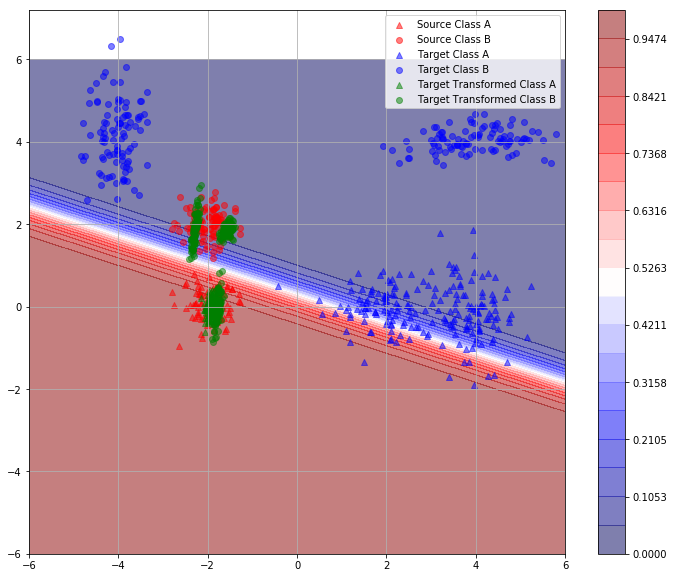

In [26]:
plt.figure(figsize=(12,10))

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logisticR.predict_proba(grid)[:, 1].reshape(xx.shape)

levels = np.linspace(0,1,20)
cm = plt.cm.seismic

cont = plt.contourf(xx, yy, probs, levels, cmap=cm, alpha=.5)



# Plot source class A (Red Triangle) and class B (Red Circle)
plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)

# Plot source class A (Blue Triangle) and class B (Blue Circle)
plt.scatter(X_target_A[:,0], X_target_A[:,1], label="Target Class A", color="blue", marker ="^", alpha=0.5)
plt.scatter(X_target_B[:,0], X_target_B[:,1], label="Target Class B", color="blue", alpha=0.5)

# Plot source class A (Green Triangle) and class B (Green Circle)
plt.scatter(X_target_transformed.detach().cpu().numpy()[:100,0], X_target_transformed.detach().cpu().numpy()[:100,1], label="Target Transformed Class A", color="green", alpha=0.5, marker ="^")
plt.scatter(X_target_transformed.detach().cpu().numpy()[100:,0], X_target_transformed.detach().cpu().numpy()[100:,1], label="Target Transformed Class B", color="green", alpha=0.5)

plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()

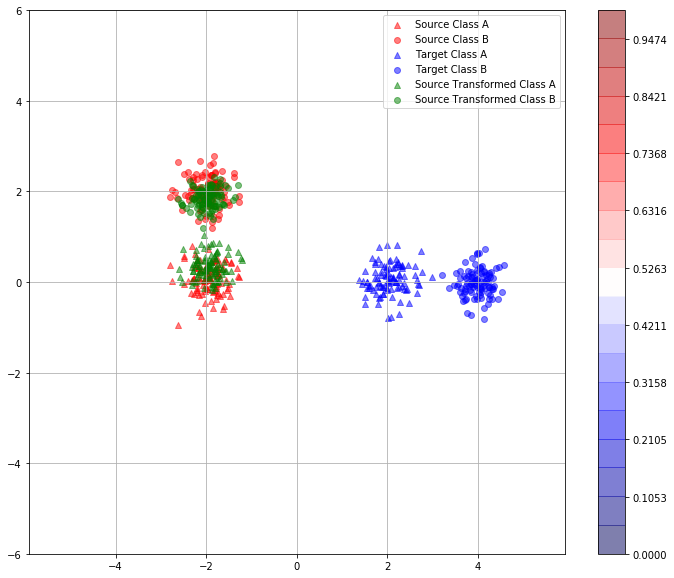

In [19]:
plt.figure(figsize=(12,10))
plt.axes().set_aspect('equal', 'datalim')
plt.axis([-6,6,-6,6])

x_min, x_max = -6, 6
y_min, y_max = -6, 6
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.seismic
points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()


plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)

plt.scatter(X_target_A[:,0], X_target_A[:,1], label="Target Class A", color="blue", marker ="^", alpha=0.5)
plt.scatter(X_target_B[:,0], X_target_B[:,1], label="Target Class B", color="blue", alpha=0.5)

plt.scatter(X_target_transformed.detach().cpu().numpy()[:100,0], X_target_transformed.detach().cpu().numpy()[:100,1], label="Source Transformed Class A", color="green", alpha=0.5, marker ="^")
plt.scatter(X_target_transformed.detach().cpu().numpy()[100:,0], X_target_transformed.detach().cpu().numpy()[100:,1], label="Source Transformed Class B", color="green", alpha=0.5)

plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()

### Summary

As observed, the transformed target domain can be classified using transformed target domain.

#### Observations

**[1]** Loss function for transformer and discriminator - Note that discriminator loss almost reaches 0 during the initial iterations because the discriminator is modelled as much power neural network and generator does not know how to fool the discriminator. 

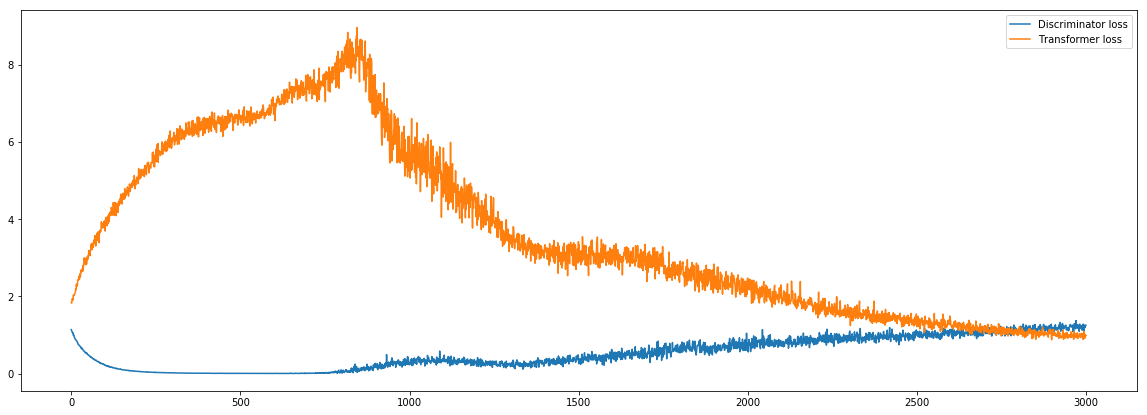

In [20]:
# k = 10
# def smooth(x_list):
#     return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.plot([i for i in range(len(D_loss_list))], D_loss_list, label="Discriminator loss")
plt.plot([i for i in range(len(T_loss_list))], T_loss_list, label="Transformer loss")
plt.legend()

**But we have only learned a linear function to solve the above problem, was this an overkill ??**

$X_{T}^{new} = W*X_{T}+B$

#### Homework

**[1]** Let's re-assign the value of co-variance of Gaussians in the target domain. 


In [21]:
## Target data. 

## class A (Blue Triangle)

n_target_A = 100
mean_target_A_1 = [+2,0]
mean_target_A_2 = [+4,0]

## Note that we changed the standard deviation of Class A
cov_target_A_1 = np.array([[0.4,0],[0,0.2]])
cov_target_A_2 = np.array([[0.2,0],[0,0.4]])



## Class B (Blue Circle)

n_target_B = 100
mean_target_B_1 = [+4,+4]
mean_target_B_2 = [-4,4]

## Note that we changed the standard deviation of Class A
cov_target_B_1 = np.array([[0.6,0],[0,0.1]])
cov_target_B_2 = np.array([[0.1,0],[0,0.6]])


# target class A

X_target_A = np.append(np.random.multivariate_normal(mean_target_A_1, cov_target_A_1, n_target_A), np.random.multivariate_normal(mean_target_A_2, cov_target_A_2, n_target_A),axis=0)
Y_target_A = np.ones(2*n_source_A)

# target class B

X_target_B = np.append(np.random.multivariate_normal(mean_target_B_1, cov_target_B_1, n_target_B), np.random.multivariate_normal(mean_target_B_2, cov_target_B_2, n_target_A),axis=0)
Y_target_B = np.zeros(2*n_target_B)

X_target_A_tensor = torch.tensor(X_target_A, dtype=torch.float32)
X_target_B_tensor = torch.tensor(X_target_B, dtype=torch.float32)

Y_target_A_tensor = torch.tensor(Y_target_A)
Y_target_B_tensor = torch.tensor(Y_target_B)

X_target_tensor_variable = convert_to_variable(torch.cat((X_target_A_tensor, X_target_B_tensor)))
X_target_label_variable = convert_to_variable(torch.cat((Y_target_A_tensor, Y_target_B_tensor)))



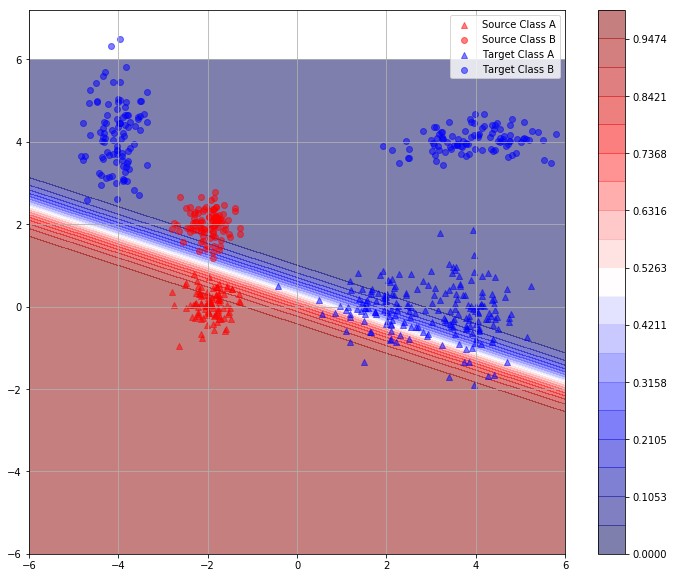

In [22]:
plt.figure(figsize=(12,10))

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logisticR.predict_proba(grid)[:, 1].reshape(xx.shape)

levels = np.linspace(0,1,20)
cm = plt.cm.seismic

cont = plt.contourf(xx, yy, probs, levels, cmap=cm, alpha=.5)

plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)

plt.scatter(X_target_A[:,0], X_target_A[:,1], label="Target Class A", color="blue", marker ="^", alpha=0.5)
plt.scatter(X_target_B[:,0], X_target_B[:,1], label="Target Class B", color="blue", alpha=0.5)


plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()


In [23]:
D_loss_list, T_loss_list = train(T, D, X_source_tensor_variable, X_target_tensor_variable)

Iteration: 0 D_loss: 2.497 T_loss: 1.508
Iteration: 100 D_loss: 0.5319 T_loss: 2.856
Iteration: 200 D_loss: 0.5778 T_loss: 3.893
Iteration: 300 D_loss: 0.6125 T_loss: 3.886
Iteration: 400 D_loss: 0.594 T_loss: 3.472
Iteration: 500 D_loss: 0.4802 T_loss: 3.022
Iteration: 600 D_loss: 0.6528 T_loss: 2.41
Iteration: 700 D_loss: 0.9123 T_loss: 1.631
Iteration: 800 D_loss: 1.21 T_loss: 1.212
Iteration: 900 D_loss: 1.136 T_loss: 1.097
Iteration: 1000 D_loss: 1.082 T_loss: 1.075
Iteration: 1100 D_loss: 1.208 T_loss: 0.9651
Iteration: 1200 D_loss: 1.048 T_loss: 1.193
Iteration: 1300 D_loss: 1.218 T_loss: 0.8856
Iteration: 1400 D_loss: 1.256 T_loss: 0.96
Iteration: 1500 D_loss: 1.23 T_loss: 0.8219
Iteration: 1600 D_loss: 1.267 T_loss: 0.8848
Iteration: 1700 D_loss: 1.322 T_loss: 0.7971
Iteration: 1800 D_loss: 1.243 T_loss: 0.827
Iteration: 1900 D_loss: 1.267 T_loss: 0.7503
Iteration: 2000 D_loss: 1.235 T_loss: 0.8035
Iteration: 2100 D_loss: 1.294 T_loss: 0.8498
Iteration: 2200 D_loss: 1.239 T_lo

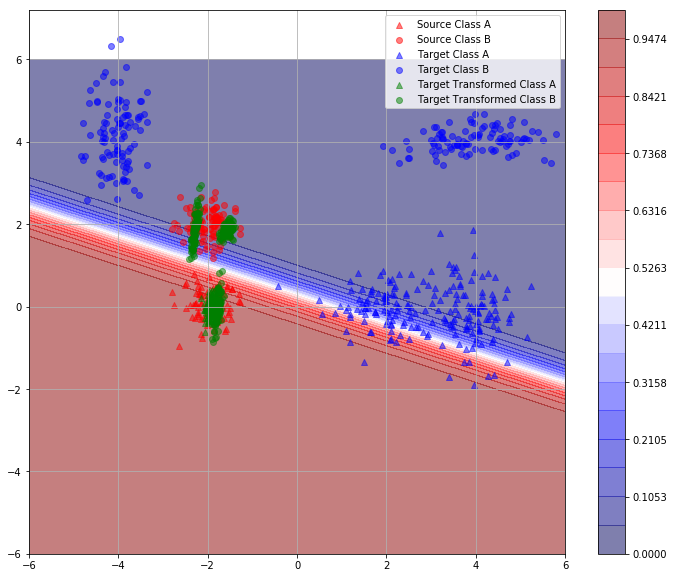

In [24]:
X_target_transformed = T(X_target_tensor_variable)

plt.figure(figsize=(12,10))

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logisticR.predict_proba(grid)[:, 1].reshape(xx.shape)

levels = np.linspace(0,1,20)
cm = plt.cm.seismic

cont = plt.contourf(xx, yy, probs, levels, cmap=cm, alpha=.5)


# Plot source class A (Red Triangle) and class B (Red Circle)
plt.scatter(X_source_A[:,0], X_source_A[:,1], label="Source Class A", color="red", marker ="^", alpha=0.5)
plt.scatter(X_source_B[:,0], X_source_B[:,1], label="Source Class B", color="red", alpha=0.5)

# Plot source class A (Blue Triangle) and class B (Blue Circle)
plt.scatter(X_target_A[:,0], X_target_A[:,1], label="Target Class A", color="blue", marker ="^", alpha=0.5)
plt.scatter(X_target_B[:,0], X_target_B[:,1], label="Target Class B", color="blue", alpha=0.5)

# Plot source class A (Green Triangle) and class B (Green Circle)
plt.scatter(X_target_transformed.detach().cpu().numpy()[:100,0], X_target_transformed.detach().cpu().numpy()[:100,1], label="Target Transformed Class A", color="green", alpha=0.5, marker ="^")
plt.scatter(X_target_transformed.detach().cpu().numpy()[100:,0], X_target_transformed.detach().cpu().numpy()[100:,1], label="Target Transformed Class B", color="green", alpha=0.5)

plt.legend()
plt.colorbar(cont, orientation="vertical")
plt.grid()

**[2]** Let's define the source as a 2-dimensional and target as a 3-dimensional distribution.